In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from IPython.display import Audio
from components.dataset import AudioBinaryClassifyDS
from components.loaders import loaders
from components.model import AudioRNNBinary
from components.trainer import Trainer
from utils.plot import plot_waveform, plot_spectrogram

In [3]:
dataset = AudioBinaryClassifyDS(
    dir1='.catdog_audio/cat/',
    dir2='.catdog_audio/dog/',
    class_dict={0: 'cat', 1: 'dog'}
)  
dataset.pre_comp(n_cut=3)

/Users/uvyadayu/anaconda3/envs/ML/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


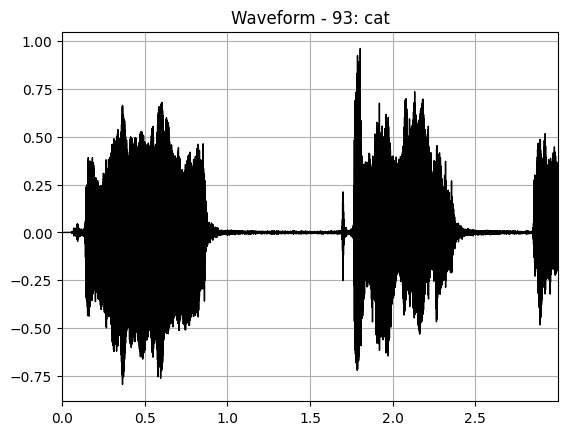

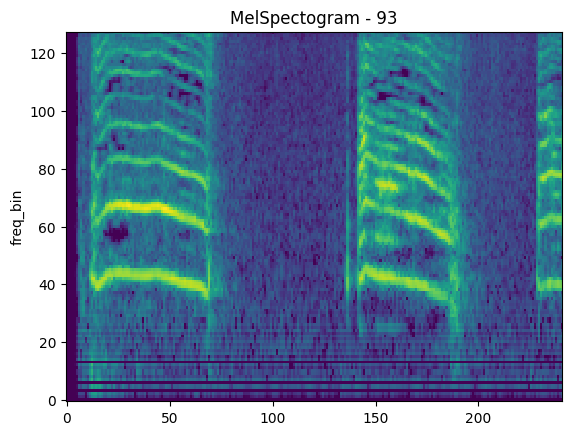

In [4]:
random_idx = random.randint(0, len(dataset))
sample = dataset[random_idx]

plot_waveform(sample['waveform'], sample['sr'], 'Waveform - {}: {}'.format(random_idx, dataset.class_dict[sample['label'].item()]))
plot_spectrogram(sample['specgram'], 'MelSpectogram - {}'.format(random_idx))
Audio(sample['waveform'], rate=sample['sr'])

In [5]:
sample['specgram'].shape

torch.Size([128, 241])

In [54]:
loaders = loaders(dataset, 32)

train: 160
val: 40


In [105]:
input_size = len(sample['specgram'][0])
hidden_size = len(sample['specgram'][0])*2

model = AudioRNNBinary(input_size, hidden_size, num_layers=2, drop_out=0.6)
trainer = Trainer(model, loaders['train'], loaders['val'])
model

AudioRNNBinary(
  (lstm): LSTM(241, 482, num_layers=2, batch_first=True, dropout=0.6)
  (fc): Sequential(
    (0): Linear(in_features=482, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

Epoch: 1/120..  Train Loss: 0.694 Valid Loss: 0.643 Train Accuracy: 0.475 Valid Accuracy: 0.703
Epoch: 2/120..  Train Loss: 0.650 Valid Loss: 0.478 Train Accuracy: 0.588 Valid Accuracy: 0.703
Epoch: 3/120..  Train Loss: 0.592 Valid Loss: 0.534 Train Accuracy: 0.600 Valid Accuracy: 0.641
Epoch: 4/120..  Train Loss: 0.598 Valid Loss: 0.550 Train Accuracy: 0.750 Valid Accuracy: 0.672
Epoch: 5/120..  Train Loss: 0.553 Valid Loss: 0.482 Train Accuracy: 0.744 Valid Accuracy: 0.719
Epoch: 6/120..  Train Loss: 0.472 Valid Loss: 0.450 Train Accuracy: 0.831 Valid Accuracy: 0.844
Epoch: 7/120..  Train Loss: 0.374 Valid Loss: 0.549 Train Accuracy: 0.850 Valid Accuracy: 0.797
Epoch: 8/120..  Train Loss: 0.335 Valid Loss: 0.437 Train Accuracy: 0.881 Valid Accuracy: 0.859
Epoch: 9/120..  Train Loss: 0.308 Valid Loss: 0.564 Train Accuracy: 0.856 Valid Accuracy: 0.812
Epoch: 10/120..  Train Loss: 0.288 Valid Loss: 0.554 Train Accuracy: 0.887 Valid Accuracy: 0.797
Epoch: 11/120..  Train Loss: 0.313 Vali

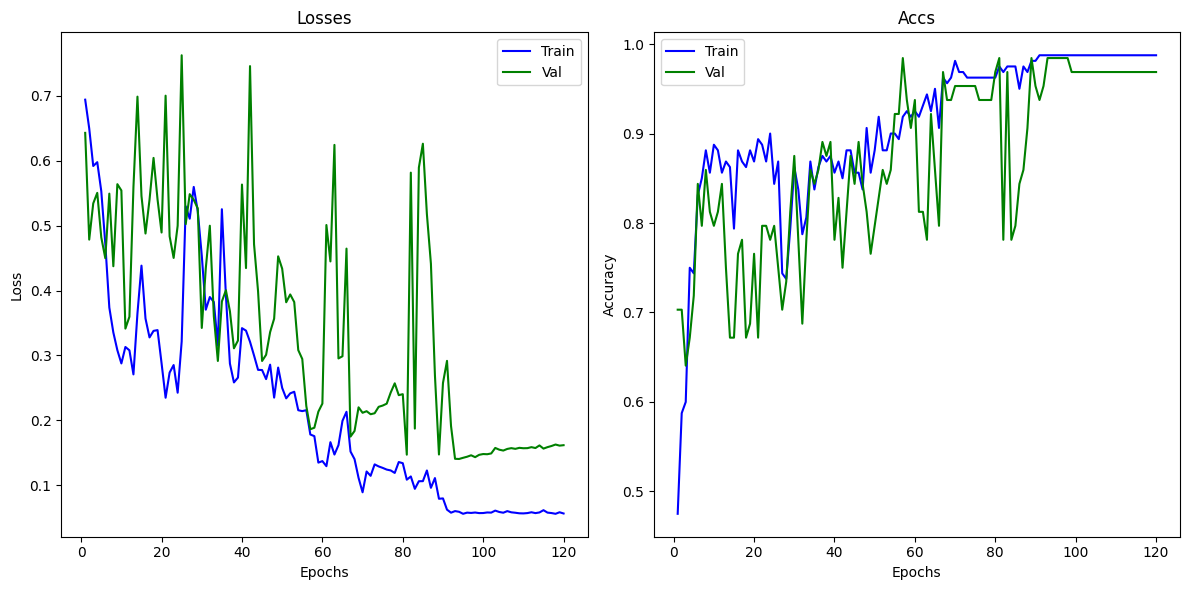

best val acc: 0.984375


In [106]:
trainer.start(120)
trainer.plot_history()
print('best val acc: {}'.format(trainer.best_acc))

In [108]:
model = trainer.load_checkpoint()
model.eval();

r = random.randint(0, loaders['val'].batch_size)
sample = loaders['val'].dataset[r]

wf = sample['waveform']
sr = sample['sr']
spec = sample['specgram']
label = sample['label'].item()

out = model(spec.unsqueeze(0).to('mps')).item()
res = 0 if out < 0.5 else 1

print('true: {}'.format(dataset.class_dict[label]))
print('pred: {}, out={}'.format(dataset.class_dict[res], out))

Audio(wf, rate=sample['sr'])

true: cat
pred: cat, out=0.002690044231712818
